# Edge and Corner Detection in Unorganized Point Clouds for Robotic Pick and Place Applications

In [1]:
!pip install pyntcloud
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.3/346.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.4 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Att

In [2]:
%%time
from pyntcloud import PyntCloud
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from sklearn.linear_model import RANSACRegressor
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
from sklearn.cluster import DBSCAN
from collections import deque
from itertools import combinations

CPU times: user 4.21 s, sys: 418 ms, total: 4.63 s
Wall time: 6 s


In [3]:
%%time
file_path = "/content/drive/MyDrive/Edge and Corner Detection in Unorganized Point Clouds/ArtificialPointClouds/Cube30KSharpEdge.pcd"
cloud = PyntCloud.from_file(file_path)

CPU times: user 60.9 ms, sys: 18 ms, total: 78.9 ms
Wall time: 2.02 s


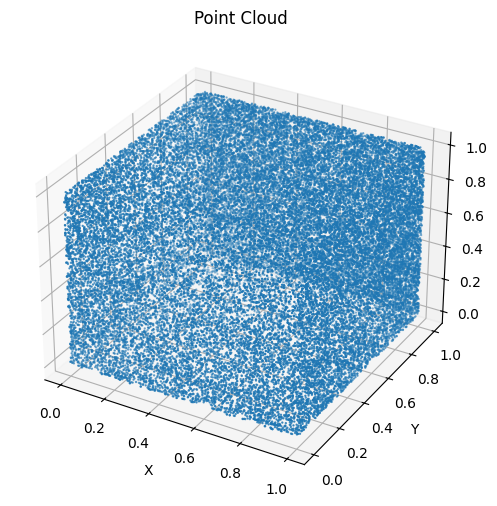

CPU times: user 2.65 s, sys: 31.5 ms, total: 2.68 s
Wall time: 2.63 s


In [4]:
%%time
df = cloud.points

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['z'], s=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Point Cloud")
plt.show()

## 1. Edge Points Extraction

In [5]:
%%time
def compute_edge_mask(pcd: PyntCloud, rs: float, th: float):
    pts = pcd.points[['x','y','z']].values
    N   = pts.shape[0]
    tree = KDTree(pts)

    scores = np.zeros(N, dtype=float)
    mask   = np.zeros(N, dtype=bool)

    for i in range(N):
        idx = tree.query_ball_point(pts[i], rs)
        idx = [j for j in idx if j != i]
        k   = len(idx)
        if k < 3:
            continue

        nbrs = pts[idx]
        diffs = nbrs - pts[i]
        norms = np.linalg.norm(diffs, axis=1)
        valid = norms > 0
        u     = diffs[valid] / norms[valid][:,None]
        if u.shape[0] < 3:
            continue

        R   = u.sum(axis=0)
        Rn  = np.linalg.norm(R)
        if Rn == 0:
            continue
        Rhat = R / Rn

        dots     = u.dot(Rhat)
        score_i  = dots.mean()
        scores[i] = score_i
        mask[i]   = (score_i > th)

    return mask, scores

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 17.2 µs


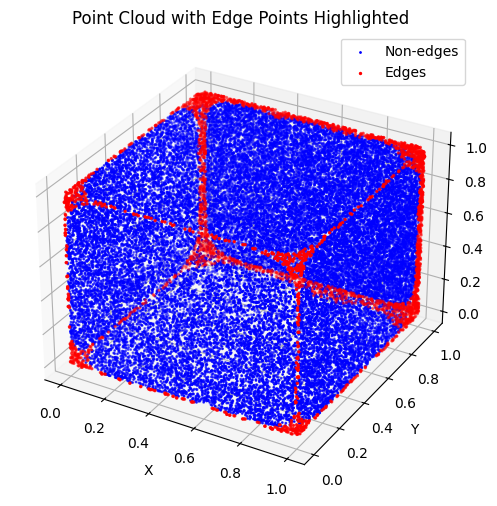

CPU times: user 22 s, sys: 131 ms, total: 22.2 s
Wall time: 24 s


In [6]:
%%time
rs = 0.2
th = 0.42

edge_mask, edge_scores = compute_edge_mask(cloud, rs, th)

xyz = cloud.points[['x','y','z']].values
x, y, z = xyz.T

fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection='3d')

ax.scatter(x[~edge_mask], y[~edge_mask], z[~edge_mask],
           c='blue', s=1, label='Non‐edges')
ax.scatter(x[ edge_mask], y[ edge_mask], z[ edge_mask],
           c='red',       s=2, label='Edges')

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
plt.legend()
plt.title("Point Cloud with Edge Points Highlighted")
plt.show()

In [7]:
%%time
df = cloud.points.copy()

df = df.dropna(subset=['x','y','z']).reset_index(drop=True)

colors = np.zeros((len(df), 3), dtype=np.uint8)
colors[~edge_mask[df.index]] = [0,   0, 255]
colors[ edge_mask[df.index]] = [255, 0,   0]

df[['red','green','blue']] = pd.DataFrame(colors, index=df.index)

colored_cloud = PyntCloud(df)

xyz = colored_cloud.points[['x','y','z']].values

pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points = o3d.utility.Vector3dVector(xyz)

if all(c in colored_cloud.points.columns for c in ('red','green','blue')):
    rgb255 = colored_cloud.points[['red','green','blue']].values
    rgb01  = rgb255.astype(float) / 255.0
    pcd_o3d.colors = o3d.utility.Vector3dVector(rgb01)

output_ply = "colored_cloud_output.ply"
o3d.io.write_point_cloud(output_ply, pcd_o3d, write_ascii=True)

CPU times: user 159 ms, sys: 4.89 ms, total: 164 ms
Wall time: 168 ms


True

## 2. Estimating the Length of Edges

In [8]:
%%time
def ransac_line(pts, n_iter=200, dist_thr=0.01, min_inliers=30):
    best_inliers = []
    best_model = None
    N = len(pts)
    for _ in range(n_iter):
        i1,i2 = np.random.choice(N,2,replace=False)
        p1,p2 = pts[i1], pts[i2]
        v = p2-p1; vn = np.linalg.norm(v)
        if vn==0: continue
        vh = v/vn
        diffs = pts - p1
        proj  = (diffs.dot(vh)[:,None])*vh[None,:]
        dists = np.linalg.norm(diffs - proj, axis=1)
        inl = np.where(dists<dist_thr)[0]
        if len(inl)>len(best_inliers):
            best_inliers, best_model = inl, (p1,vh)
    if best_model is None or len(best_inliers)<min_inliers:
        return None, None
    return best_model, best_inliers

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [9]:
%%time
def get_reference_index(pts, rs):
    tree = KDTree(pts)
    counts = [len(tree.query_ball_point(pts[i], rs)) for i in range(len(pts))]
    return int(np.argmax(counts))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [10]:
%%time
def get_extreme_points(pts: np.ndarray, ref_idx: int, rs: float):
    tree = KDTree(pts)
    pr = pts[ref_idx]

    candidates = []

    for i, pi in enumerate(pts):
        if i == ref_idx:
            continue

        nbr_idx = [j for j in tree.query_ball_point(pi, rs) if j != i]
        if len(nbr_idx) == 0:
            continue

        d1 = pr - pi
        d1_norm = np.linalg.norm(d1)
        if d1_norm == 0:
            continue
        d1_hat = d1 / d1_norm

        all_pos = True
        for j in nbr_idx:
            d2 = pts[j] - pi
            d2_norm = np.linalg.norm(d2)
            if d2_norm == 0:
                continue
            d2_hat = d2 / d2_norm

            if np.dot(d1_hat, d2_hat) < 0:
                all_pos = False
                break

        if all_pos:
            candidates.append((i, d1_norm, d1_hat))

    if len(candidates) < 2:
        raise RuntimeError("Not enough extreme candidates found.")

    candidates.sort(key=lambda x: x[1])
    e1_idx, e1_dist, e1_dir = candidates[0]

    opposite = [c for c in candidates[1:]
                if np.dot(e1_dir, c[2]) < 0]
    if not opposite:
        e2_idx = candidates[1][0]
    else:
        e2_idx = min(opposite, key=lambda x: x[1])[0]

    return e1_idx, e2_idx

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11 µs


In [11]:
%%time
def extract_all_edges(xyz_e, dist_thr=0.01, min_inliers=30, n_iter=200):
    mask  = np.ones(len(xyz_e), bool)
    edges = []

    while True:
        idxs = np.where(mask)[0]
        if len(idxs) < min_inliers:
            break

        subset = xyz_e[idxs]
        model, inliers = ransac_line(
            subset,
            n_iter=n_iter,
            dist_thr=dist_thr,
            min_inliers=min_inliers
        )
        if model is None:
            break

        p0, v = model

        pts_inl = subset[inliers]
        t_vals  = (pts_inl - p0).dot(v)

        i1, i2 = np.argmin(t_vals), np.argmax(t_vals)
        orig_e1 = idxs[inliers[i1]]
        orig_e2 = idxs[inliers[i2]]

        edges.append((orig_e1, orig_e2))

        mask[idxs[inliers]] = False

    residual = xyz_e[mask]
    return edges, residual

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10 µs


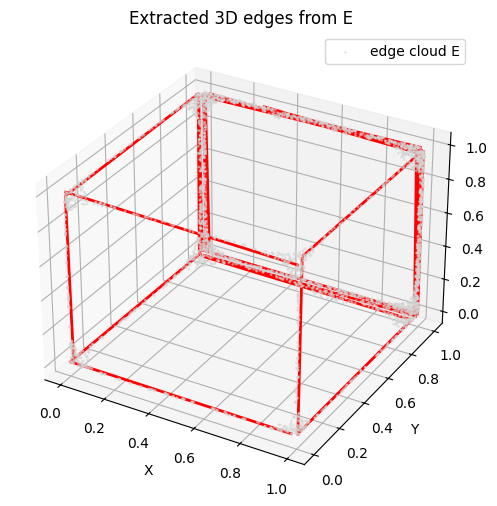

CPU times: user 21.7 s, sys: 120 ms, total: 21.8 s
Wall time: 22.7 s


In [20]:
%%time
rs = 0.2
th = 0.42
edge_mask, edge_scores = compute_edge_mask(cloud, rs, th)

xyz = cloud.points[['x','y','z']].values
xyz_e = xyz[edge_mask]

A, residual = extract_all_edges(xyz_e, dist_thr=0.01, min_inliers=50, n_iter=200)

fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(xyz_e[:,0], xyz_e[:,1], xyz_e[:,2],
           c='lightgray', s=1, alpha=0.5, label='edge cloud E')
for (i1,i2) in A:
    p1, p2 = xyz_e[i1], xyz_e[i2]
    ax.plot([p1[0],p2[0]],
            [p1[1],p2[1]],
            [p1[2],p2[2]],
            linewidth=2, c='red')
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
plt.title("Extracted 3D edges from E")
plt.legend()
plt.show()

## 4. Pose Refinement

In [21]:
%%time
def edge_dir(edge):
    p, q = xyz_e[edge[0]], xyz_e[edge[1]]
    return (q - p) / np.linalg.norm(q - p)


def line_dist(ea, eb):
    p1, d1 = xyz_e[ea[0]], edge_dir(ea)
    p2, d2 = xyz_e[eb[0]], edge_dir(eb)
    n = np.cross(d1, d2)
    if np.linalg.norm(n) < 1e-6:
        return np.inf
    return abs(np.dot(n, p2 - p1)) / np.linalg.norm(n)


def find_best_edge_pair(A):
    scores = []
    for ea, eb in itertools.combinations(A, 2):
        alpha = abs(np.dot(edge_dir(ea), edge_dir(eb)))
        delta = line_dist(ea, eb)
        scores.append((tuple(ea), tuple(eb), alpha, delta))
    scores.sort(key=lambda x: (x[2], x[3]))
    return scores[0]


def cluster_cube_edges(A, xyz_e, seed, inters_tol=5e-3):
    ea, eb, _, _ = seed
    def intersects(e1, e2):
        return line_dist(e1, e2) < inters_tol

    C_full = set([ea, eb])
    queue = deque([ea, eb])
    while queue:
        curr = queue.popleft()
        d1 = edge_dir(curr)
        for cand in A:
            cand = tuple(cand)
            if cand in C_full:
                continue
            d2 = edge_dir(cand)
            if abs(np.dot(d1, d2)) < 0.1 and intersects(curr, cand):
                C_full.add(cand)
                queue.append(cand)
    d_axis1 = edge_dir(ea)
    d_axis2 = edge_dir(eb)
    d_axis3 = np.cross(d_axis1, d_axis2)
    axes = [d_axis1, d_axis2, d_axis3]
    groups = {0: [], 1: [], 2: []}
    for e in C_full:
        d = edge_dir(e)
        scores = [abs(np.dot(d, ax)) for ax in axes]
        idx = int(np.argmax(scores))
        groups[idx].append(e)
    C_final = []
    for idx, segs in groups.items():
        lengths = [(e, np.linalg.norm(xyz_e[e[1]] - xyz_e[e[0]])) for e in segs]
        lengths.sort(key=lambda x: x[1], reverse=True)
        if len(lengths) < 4:
            raise RuntimeError(f"Axis {idx} only has {len(lengths)} segments; expected ≥4")
        C_final.extend([e for e, _ in lengths[:4]])
    return C_final

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 12.6 µs


In [22]:
%%time
def intersect_lines(ea, eb, xyz_e):

    p1, p2 = xyz_e[ea[0]], xyz_e[eb[0]]
    d1 = (xyz_e[ea[1]] - p1); d1 /= np.linalg.norm(d1)
    d2 = (xyz_e[eb[1]] - p2); d2 /= np.linalg.norm(d2)
    A = np.stack([d1, -d2], axis=1)    # 3×2
    b = p2 - p1
    uv, *_ = np.linalg.lstsq(A, b, rcond=None)
    pt1 = p1 + uv[0]*d1
    pt2 = p2 + uv[1]*d2
    return (pt1 + pt2)/2

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.06 µs


In [23]:
%%time
def pose_from_two_edges(e1, e2, xyz_e, dims):
    ℓ, b, h = dims

    p1 = intersect_lines(e1, e2, xyz_e)
    pts1 = [xyz_e[e1[0]], xyz_e[e1[1]]]
    pts2 = [xyz_e[e2[0]], xyz_e[e2[1]]]

    p2 = pts1[0] if np.linalg.norm(pts1[1]-p1) > np.linalg.norm(pts1[0]-p1) else pts1[1]
    p3 = pts2[0] if np.linalg.norm(pts2[1]-p1) > np.linalg.norm(pts2[0]-p1) else pts2[1]

    obs_l = np.linalg.norm(p2 - p1)
    obs_b = np.linalg.norm(p3 - p1)
    if abs(obs_l - b) < abs(obs_l - ℓ):
        ℓ, b = b, ℓ

    d1 = (p2-p1); d1 /= np.linalg.norm(d1)
    d2 = (p3-p1); d2 /= np.linalg.norm(d2)
    t  = -p1 / np.linalg.norm(p1)
    d  = np.cross(d1, d2); d /= np.linalg.norm(d)

    if np.dot(d, t) < 0:
        d1f = -d1; df = np.cross(d1f, d2)
        if np.dot(df, t) > 0:
            d1, d = d1f, df/np.linalg.norm(df)
        else:
            d2 = -d2
            d  = np.cross(d1, d2); d /= np.linalg.norm(d)

    R = np.stack([d1, d2, d], axis=1)

    local_p1 = np.array([-ℓ/2, -b/2, +h/2])
    local_p2 = np.array([+ℓ/2, -b/2, +h/2])
    local_p3 = np.array([-ℓ/2, +b/2, +h/2])

    T1 = p1 - R.dot(local_p1)
    T2 = p2 - R.dot(local_p2)
    T3 = p3 - R.dot(local_p3)
    T  = (T1 + T2 + T3) / 3.0

    return R, T

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [24]:
%%time
import itertools
from sklearn.cluster import KMeans
def get_observed_corners(C, xyz_e, orth_tol=0.05):
    directions = []
    for e in C:
        v = edge_dir(e)
        added = False
        for group in directions:
            if abs(np.dot(group[0], v)) > 0.95:
                group.append(v)
                added = True
                break
        if not added:
            directions.append([v])

    points = set()
    for e in C:
        points.add(tuple(xyz_e[e[0]]))
        points.add(tuple(xyz_e[e[1]]))

    unique = []
    for p in map(np.array, points):
        if not any(np.linalg.norm(p - q) < 1e-3 for q in unique):
            unique.append(p)
    return np.array(unique)

def refine_pose(R_init, T_init, C, xyz_e, dims):
    obs = get_observed_corners(C, xyz_e)
    l, b, h = dims
    signs = list(itertools.product([-1,1], repeat=3))
    model = np.array([[sx*l/2, sy*b/2, sz*h/2] for sx,sy,sz in signs])
    preds = (R_init @ model.T).T + T_init
    tol = max(l,b,h) * 0.1
    corr = []
    for ml, wp in zip(model, preds):
        dists = np.linalg.norm(obs - wp, axis=1)
        j = np.argmin(dists)
        if dists[j] < tol:
            corr.append((ml, obs[j]))
    if len(corr) < 3:
        print("⚠️ Too few correspondences; skipping refinement.")
        return R_init, T_init
    Ls = np.array([c[0] for c in corr])
    Ws = np.array([c[1] for c in corr])
    cL = Ls.mean(0)
    cW = Ws.mean(0)
    H  = (Ls - cL).T @ (Ws - cW)
    U, S, Vt = np.linalg.svd(H)
    R_ref = Vt.T @ U.T
    if np.linalg.det(R_ref) < 0:
        Vt[-1,:] *= -1
        R_ref = Vt.T @ U.T
    T_ref = cW - R_ref @ cL
    return R_ref, T_ref

CPU times: user 21 µs, sys: 0 ns, total: 21 µs
Wall time: 25.3 µs


In [25]:
%%time
rs, th = 0.2, 0.42
edge_mask, edge_scores = compute_edge_mask(cloud, rs, th)
xyz     = cloud.points[['x', 'y', 'z']].values
xyz_e   = xyz[edge_mask]
A, _    = extract_all_edges(xyz_e, dist_thr=0.01, min_inliers=50, n_iter=200)

CPU times: user 20.7 s, sys: 125 ms, total: 20.9 s
Wall time: 21.1 s


Seed pair |dot|=0.0000, dist=0.9896
Clustered edges: 12
Initial R:
 [[-9.9723923e-01 -9.9763620e-01 -5.3145893e-02]
 [ 7.5391121e-03  6.8715520e-02 -7.6725399e-01]
 [ 7.3872603e-02  4.6627148e-04 -6.3913763e-01]]
Initial T:
 [0.48935159 0.02573863 0.9975875 ]
⚠️ Too few correspondences; skipping refinement.
Refined R:
 [[-9.9723923e-01 -9.9763620e-01 -5.3145893e-02]
 [ 7.5391121e-03  6.8715520e-02 -7.6725399e-01]
 [ 7.3872603e-02  4.6627148e-04 -6.3913763e-01]]
Refined T:
 [0.48935159 0.02573863 0.9975875 ]


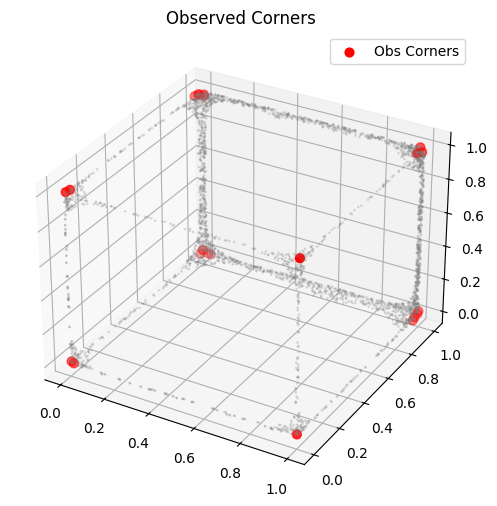

CPU times: user 508 ms, sys: 2.97 ms, total: 511 ms
Wall time: 551 ms


In [26]:
%%time
seed = find_best_edge_pair(A)
ea, eb, alpha, delta = seed
print(f"Seed pair |dot|={alpha:.4f}, dist={delta:.4f}")

C = cluster_cube_edges(A, xyz_e, seed)
print(f"Clustered edges: {len(C)}")

dims = (0.03, 0.03, 0.03)
R_init, T_init = pose_from_two_edges(ea, eb, xyz_e, dims)
print("Initial R:\n", R_init)
print("Initial T:\n", T_init)

R_ref, T_ref = refine_pose(R_init, T_init, C, xyz_e, dims)
print("Refined R:\n", R_ref)
print("Refined T:\n", T_ref)

obs_c = get_observed_corners(C, xyz_e)
model_c = np.array([[sx*dims[0]/2, sy*dims[1]/2, sz*dims[2]/2]
                    for sx,sy,sz in itertools.product([-1,1], repeat=3)])
world_c = (R_ref @ model_c.T).T + T_ref
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(xyz_e[:,0], xyz_e[:,1], xyz_e[:,2], c='gray', s=1, alpha=0.2)
ax.scatter(obs_c[:,0], obs_c[:,1], obs_c[:,2], c='red',   label='Obs Corners', s=40)
ax.legend(); plt.title('Observed Corners'); plt.show()



> Vohra, M., Prakash, R., & Behera, L. (2021). Edge and Corner Detection in Unorganized Point Clouds for Robotic Pick and Place Applications.

